<a href="https://colab.research.google.com/github/Bourbon-Rye/Baesian-Cropability/blob/main/PilipiNuts_2023_Baesian_Cropability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Note: See Hypothesis Testing RESULTS in `results/`.

**Parameters:**
* Set `INTERACTIVE` to True for interactive plots and to False for static plots.
* Set `REGENERATE` to True to regenerate plots and to False to not regenerate plots.

In [2017]:
# @title Libraries
import numpy as np
import pandas as pd
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import json
import re
import functools

from pathlib import Path
from sklearn import preprocessing
from plotly.subplots import make_subplots
from plotly import offline
from scipy import stats
from sklearn.impute import SimpleImputer
from matplotlib import figure

import warnings
# from warnings import simplefilter
# simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore')

# @title Parameters
INTERACTIVE = False
REGENERATE = False

def render(fig: figure.Figure):
    if INTERACTIVE:
        fig.show()
    else:
        fig.update_layout(
            autosize=False,
            width=1280,
            height=720,
        )
        fig.show(renderer="png")

In [2018]:
# @title Geolocation Filters and Corrections
with open('datasets/region_provinces.json') as jsonfile:
    regions_provinces = json.load(jsonfile)['PHILIPPINES']
regions_provinces = {key.lower():regions_provinces[key] for key in regions_provinces}
regions = regions_provinces.keys()
provinces = set([item.lower() for key in regions for item in regions_provinces[key]])
regions = set(regions)
regions.add("philippines")

# NOTE: Fix for bad regions, thanks PSA
bad_regions = ['AONCR', 'BARMM', 'CAR', 'MIMAROPA', 'NCR',
           'Region 1', 'Region 2', 'Region 3', 'Region 4A',
           'Region 5', 'Region 6', 'Region 7', 'Region 8',
           'Region 9', 'Region 10', 'Region 11', 'Reg12', 'CARAGA']
region_mapping = {bad.lower():good.lower() for (bad,good) in zip(bad_regions, regions_provinces.keys())}
corrections = {
    "AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)": "bangsamoro autonomous region in muslim mindanao (barmm)",
    "autonomous region in muslim mindanao (armm)": "bangsamoro autonomous region in muslim mindanao (barmm)",
    "mimaropa region": "mimaropa region (mimaropa)"
}
region_mapping.update(corrections)  # NOTE: Set regions to 

# Create mappings of regions from short to long and long to short
# Ex: ncr: national capital region (ncr), and vice-versa
temp = [key.split('(')[1].rstrip(')') for key in regions_provinces]
region_short_to_long = {bad:good for (bad,good) in zip(temp, regions_provinces.keys())}
region_long_to_short = {v: k for k, v in region_short_to_long.items()}
display(region_mapping)
display(regions)

{'aoncr': 'areas outside national capital region (aoncr)',
 'barmm': 'bangsamoro autonomous region in muslim mindanao (barmm)',
 'car': 'cordillera administrative region (car)',
 'mimaropa': 'mimaropa region (mimaropa)',
 'ncr': 'national capital region (ncr)',
 'region 1': 'region i (ilocos region)',
 'region 2': 'region ii (cagayan valley)',
 'region 3': 'region iii (central luzon)',
 'region 4a': 'region iv-a (calabarzon)',
 'region 5': 'region v (bicol region)',
 'region 6': 'region vi (western visayas)',
 'region 7': 'region vii (central visayas)',
 'region 8': 'region viii (eastern visayas)',
 'region 9': 'region ix (zamboanga peninsula)',
 'region 10': 'region x (northern mindanao)',
 'region 11': 'region xi (davao region)',
 'reg12': 'region xii (soccsksargen)',
 'caraga': 'region xiii (caraga)',
 'AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)': 'bangsamoro autonomous region in muslim mindanao (barmm)',
 'autonomous region in muslim mindanao (armm)': 'bangsamoro autonomous region

{'areas outside national capital region (aoncr)',
 'bangsamoro autonomous region in muslim mindanao (barmm)',
 'cordillera administrative region (car)',
 'mimaropa region (mimaropa)',
 'national capital region (ncr)',
 'philippines',
 'region i (ilocos region)',
 'region ii (cagayan valley)',
 'region iii (central luzon)',
 'region iv-a (calabarzon)',
 'region ix (zamboanga peninsula)',
 'region v (bicol region)',
 'region vi (western visayas)',
 'region vii (central visayas)',
 'region viii (eastern visayas)',
 'region x (northern mindanao)',
 'region xi (davao region)',
 'region xii (soccsksargen)',
 'region xiii (caraga)'}

In [2019]:
# @title QOL Utilities
def is_region(x: str, regions=regions) -> bool:
    x = x.strip(' .')
    x = x.lower()
    if x == "cagayan":
        return False
    for region in regions:
        if x in region:
            return True
    else:
        return False
    
def is_province(x: str, provinces=provinces) -> bool:
    x = x.strip(' .')
    x = x.lower()
    for province in provinces:
        if x in province:
            return True
    else:
        return False

def get_quarter_columns(df: pd.DataFrame, year_range: range, period_idx: int):
    """Assumes contiguous period (Year Month) columns and that columns before period_idx are ID columns.
    Converts (Year Months) into (Year Qi)."""
    df_quarter = df.iloc[:, :period_idx].copy()
    for year in year_range:
        for q in range(0, 12, 3):
            df_quarter[f"{year} Q{q//3+1}"] = df.filter(regex=str(year), axis=1).iloc[:, q:q+3].mean(axis=1)
    return df_quarter.copy()

def get_annual_columns(df: pd.DataFrame, year_range: range, period_idx: int):
    """Assumes contiguous period (Year Month|Quarter) columns and that columns before period_idx are ID columns
    Note that this also works with Quarters as shown in the format above."""
    df_annual = df.iloc[:, :period_idx].copy()
    for year in year_range:
        df_annual[f"{year}"] = df.filter(regex=str(year), axis=1).mean(numeric_only=True, axis=1)
    return df_annual

def swap_columns(df: pd.DataFrame, col1: str, col2: str):
    """Swaps col1 and col2 in a dataframe."""
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

def normalize(df: pd.DataFrame, col: str, minmax = True):
    """Normalizes a column in a dataframe.
    Can use mean normalization and minmax normalization."""
    tdf = df[col]
    if minmax:
        tdf = (tdf-tdf.min())/(tdf.max()-tdf.min())
    else:
        tdf = (tdf-tdf.mean())/tdf.std()
    df[col] = tdf
    return df

def drop_rows_with_zeros(df: pd.DataFrame, ref_col_idx: int, all_zeros=False):
    """Drop rows if some values are zeros, or if all values are zeros.
    Assumes contiguous reference columns (columns including and after ref_col_idx), i.e. columns to use in deciding whether to drop."""
    return df[~(df.iloc[:, ref_col_idx:] == 0).all(axis=1)] if all_zeros else df[~(df.iloc[:, ref_col_idx:] == 0).any(axis=1)]

def dual_plot(df: pd.DataFrame, x: str, y1: str, y2: str,
              title=None, xtitle=None, y1title=None, y2title=None):
    """A plot with 2 y-axes shared by a single x-axis with 2 line graphs."""
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Add traces
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y1], name=y1),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y2], name=y2),
        secondary_y=True,
    )
    # # Add titles
    if title is not None: fig.update_layout(title_text=title)
    if xtitle is not None: fig.update_xaxes(title_text=xtitle)
    if y1title is not None: fig.update_yaxes(title_text=y1title, secondary_y=False)
    if y2title is not None: fig.update_yaxes(title_text=y2title, secondary_y=True)

    return fig

def triplet_plot(df: pd.DataFrame, x: str, y1_1: str, y1_2: str, y2: str,
                 title=None, xtitle=None, y1title=None, y2title=None):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Add traces
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y1_1], name=y1_1),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y1_2], name=y1_2),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y2], name=y2),
        secondary_y=True,
    )
    # # Add titles
    if title is not None: fig.update_layout(title_text=title)
    if xtitle is not None: fig.update_xaxes(title_text=xtitle)
    if y1title is not None: fig.update_yaxes(title_text=y1title, secondary_y=False)
    if y2title is not None: fig.update_yaxes(title_text=y2title, secondary_y=True)

    return fig

def quartet_plot(df: pd.DataFrame, x: str, y1_1: str, y1_2: str, y2_1: str, y2_2: str,
                 title=None, xtitle=None, y1title=None, y2title=None):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Add traces
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y1_1], name=y1_1),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y1_2], name=y1_2),
        secondary_y=True,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y2_1], name=y2_1),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y2_2], name=y2_2),
        secondary_y=True,
    )
    # # Add titles
    if title is not None: fig.update_layout(title_text=title)
    if xtitle is not None: fig.update_xaxes(title_text=xtitle)
    if y1title is not None: fig.update_yaxes(title_text=y1title, secondary_y=False)
    if y2title is not None: fig.update_yaxes(title_text=y2title, secondary_y=True)

    return fig

def move_column(df: pd.DataFrame, col: str, new_idx: int):
    """This is an inplace method."""
    df.insert(new_idx, col, df.pop(col))

def imputer(df: pd.DataFrame, start_idx: int, end_idx=None):
    """If only start index is provided, will impute from start index column to last column,
    else limit from start_idx to end_idx. Inplace imputation"""
    imp = SimpleImputer(missing_values=pd.NA, strategy='mean')
    if end_idx:
        imp.fit(df.iloc[:, start_idx:end_idx])
        df[df.columns[start_idx:end_idx]] = imp.transform(df.iloc[:, start_idx:])
    else:
        imp.fit(df.iloc[:, start_idx:])
        df[df.columns[start_idx:]] = imp.transform(df.iloc[:, start_idx:])

def preprocess_baesians_2(df: pd.DataFrame, commodity_map: dict, melt_value: str|None, regional=True, impute=False):
    """Assumes Geolocation | Commodity | Period ... columns.
    Filters to regional if regional=True, else filters to provincial. Retains "philippines".
    Filters to raw commodity name (key in commodity_map), and then renames to standard commodity_map[key]
    Ex. {"RICE, REGULAR-MILLED, 1 KG" : "Rice"}
    """
    df["Geolocation"] = df["Geolocation"].str.lstrip(".").str.lower()
    df["Geolocation"] = df["Geolocation"].replace(region_mapping)
    df = df[df["Geolocation"].apply(is_region)] if regional else df[df["Geolocation"].apply(is_province)]
    df = df[df["Commodity"].isin(commodity_map)]
    df.loc[:, "Commodity"] = df["Commodity"].replace(commodity_map)
    if melt_value:
        df = df.melt(id_vars=["Geolocation", "Commodity"], value_vars=df.columns[2:], var_name="Period", value_name=melt_value)
    if impute:
        imputer(df, 3)  # inplace imputation of melt_value
    return df

def filter_to_regions(df: pd.DataFrame):
    return df[df["Geolocation"].apply(is_region)]
    
def filter_to_provinces(df: pd.DataFrame):
    return df[df["Geolocation"].apply(is_province)]

def fig_to_div(fig: figure.Figure, filename: Path):
    """Optional: Add pretiffication."""
    filename = Path(filename)
    filename.parent.mkdir(exist_ok=True, parents=True)
    with open(filename, "w+") as f:
        f.write(offline.plot(fig, include_plotlyjs=False, output_type='div'))
        
def fig_to_html(fig: figure.Figure, filename: Path):
    filename = Path(filename)
    filename.parent.mkdir(exist_ok=True, parents=True)
    fig.write_html(filename)
    
def fig_to_png(fig: figure.Figure, filename: Path, transparent=False):
    """NOTE: Requires ORCA to be installed!"""
    filename = Path(filename)
    filename.parent.mkdir(exist_ok=True, parents=True)
    if transparent:
        fig.update_layout({
            "plot_bgcolor": "rgba(0, 0, 0, 0)",
            "paper_bgcolor": "rgba(0, 0, 0, 0)",
        })
    pio.write_image(fig, filename,scale=6, width=900, height=680)
    
def p_report(p: int) -> str|int:
    """Formats p-value for reporting"""
    if p >= 0.001:
        return round(p, 3)
    elif p < 0.001:
        return "<0.001"
    else:
        return np.nan

def convert_to_short_month(df):
    month_map = {
        "January": "Jan", "February": "Feb", "March": "Mar", "April": "Apr", "May": "May", "June": "Jun",
        "July": "Jul", "August": "Aug", "September": "Sep", "October": "Oct", "November": "Nov", "December": "Dec"
    }
    tdf = df.copy()
    new_cols = []
    for column_name in tdf.columns:
        for full_month, short_month in month_map.items():
            column_name = column_name.replace(full_month, short_month)
        new_cols.append(column_name)
    tdf.columns = new_cols
    return tdf

def remove_annuals(df):
    columns_to_keep = [col for col in df.columns if 'Annual' not in col]
    tdf = df[columns_to_keep]
    
    return tdf




## Annual Analysis
Annual-National and Annual-Regional analysis of the commodities Rice and Corn. Other major crops to follow.

**NOTE:** The core agricultural indicators are Stocks, Volume, and Area Harvested, while the core market indicators are Farmgate Price, Wholesale Price, and Retail Price.

This is important to know especially during visualization where Farmgate price is used as a slicer.

### Data Preprocessing
Imputations performed here compared to `data_exporation.ipynb`.

In [2020]:
# df1 = pd.read_csv("datasets/prices/2M4AFN01.csv")
# df2 = pd.read_csv("datasets/prices/2M4AFP01.csv", skiprows=2)
# tdf = pd.concat([df2, df1], axis=1)
# tdf = convert_to_short_month(tdf)
# display(tdf.head(1))
# tdf.to_csv("datasets/prices/prices_farmgate-new-series_1990-2023.csv", index=False)

# df1 = pd.read_csv("datasets/prices/2M4AWA01.csv")
# df2 = pd.read_csv("datasets/prices/2M4AWP01.csv", skiprows=2)
# tdf = pd.concat([df2, df1], axis=1)
# tdf = convert_to_short_month(tdf)
# display(tdf.head(1))
# tdf.to_csv("datasets/prices/prices_wholesale-new-series_1990-2023.csv", index=False)

df1 = pd.read_csv("datasets/prices/2M4ARP01.csv", skiprows=2)
df2 = pd.read_csv("datasets/prices/2M4ARA01.csv")
tdf = pd.concat([df1, df2], axis=1)
tdf = convert_to_short_month(tdf)
tdf.to_csv("datasets/prices/prices_retail_1990-2023.csv", index=False)
tdf.head(1)

df1 = pd.read_csv("datasets/price-indices-2018-based/0042M4ARPI4.csv", skiprows=2)
df2 = pd.read_csv("datasets/price-indices-2018-based/2M4ARPI1.csv")
tdf = pd.concat([df1, df2], axis=1)
tdf = convert_to_short_month(tdf)
tdf = tdf.rename({"Geographic location": "Geolocation", "Commodity Description": "Commodity"}, axis=1)
tdf.to_csv("datasets/price-indices-2018-based/rpi-in-ncr_food-only_1989-2023_new.csv", index=False)
tdf.head(1)

,Geolocation,Commodity,1989 Jan,1989 Feb,1989 Mar,1989 Apr,1989 May,1989 Jun,1989 Jul,1989 Aug,...,2023 Mar,2023 Apr,2023 May,2023 Jun,2023 Jul,2023 Aug,2023 Sep,2023 Oct,2023 Nov,2023 Dec
0,NATIONAL CAPITAL REGION,..Food,28.963415,28.780488,28.47561,28.47561,28.902439,29.512195,29.878049,30.365854,...,143,143.5,144,144.4,144.6,145.1,145.3,145.6,145.9,146.3


In [2021]:
# @title Annual megadataset for rice and corn
# NOTE: Filter this during visualization and analysis to just Philippines or Regions
def filter_period(df: pd.DataFrame, _type: str):
    if _type == "Annual":
        df = df.filter(regex="Commodity|Geolocation|Annual", axis=1)
        df.columns = map(lambda x: x.replace(" Annual", "") if "Annual" in x else x, df.columns)
    elif _type == "Quarterly":
        df = df.filter(regex=r"Commodity|Geolocation|Q\d", axis=1)
    return df

# Volume of Rice and Corn
df1 = pd.read_csv("datasets/agricultural-indicators/volume_rice-corn.csv", skiprows=2, na_values=[".."])
df1 = filter_period(df1, "Annual")
df1 = preprocess_baesians_2(df1, {"Palay": "Rice", "Corn": "Corn"}, melt_value="Volume")

# Farmgate Price of Rice and Corn
df2 = pd.read_csv("datasets/prices/prices_farmgate-new-series_1990-2023.csv", na_values=[".."])
df2 = filter_period(df2, "Annual")
df2 = preprocess_baesians_2(df2, {"Palay [Paddy] Other Variety, dry (conv. to 14% mc)": "Rice",
                                  "Corngrain [Maize] Yellow, matured": "Corn"}, melt_value="Farmgate Price", impute=True)

# Wholesale Price of Rice and Corn
df3 = pd.read_csv("datasets/prices/prices_wholesale-new-series_1990-2023.csv", na_values=[".."])
df3 = filter_period(df3, "Annual")
df3 = preprocess_baesians_2(df3, {"Well Milled Rice (WMR)": "Rice",
                                  "Corngrits Yellow": "Corn"}, melt_value="Wholesale Price", impute=True)

# Retail Price of Rice and Corn
df4 = pd.read_csv("datasets/prices/prices_retail_1990-2023.csv", na_values=[".."])
df4 = filter_period(df4, "Annual")
df4 = preprocess_baesians_2(df4, {
                                  "Regular Milled Rice (RMR)" : "Rice",
                                  'Corngrain Yellow': "Corn"}, melt_value="Retail Price", impute=True)

# Area Harvested of Rice and Corn
df5 = pd.read_csv("datasets/agricultural-indicators/area-harvested-palay-corn_quarterly-annual_1987-2023.csv", skiprows=2)
df5 = filter_period(df5, "Annual")
df5 = preprocess_baesians_2(df5, {"Palay": "Rice", "Corn": "Corn"}, melt_value="Area Harvested")

# Consumer Price Index (All Income) per Region of Rice and Corn
df6 = pd.read_csv("datasets/price-indices-2018-based/cpi_all-income-households-by-cg-with-backcasting_1994-2023.csv")
df6 = get_annual_columns(df6, range(2012, 2024), 2)
df6 = preprocess_baesians_2(df6, {"01.1.1.12 - Rice": "Rice",
                                  "01.1.1.16 - Corn": "Corn"},
                            melt_value="CPI All Income")

# Consumer Price Index (Bottom 30) per Region of Rice and Corn
df7 = pd.read_csv("datasets/price-indices-2018-based/cpi_bottom-30-by-cg-with-backcasting_2012-2017.csv")
df7 = preprocess_baesians_2(df7, {"01.1.1.12 - Rice": "Rice", "01.1.1.16 - Corn": "Corn"}, melt_value=None)
tdf = pd.read_csv("datasets/price-indices-2018-based/cpi_bottom-30-by-cg_2018-2023.csv")
tdf = preprocess_baesians_2(tdf, {"01.1.1.12 - Rice": "Rice", "01.1.1.16 - Corn": "Corn"}, melt_value=None)
df7 = pd.merge(df7, tdf, on=["Geolocation", "Commodity"])
df7 = get_annual_columns(df7, range(2012, 2024), 2)
df7 = preprocess_baesians_2(df7, {"Rice": "Rice", "Corn": "Corn"}, melt_value="CPI Bottom 30")

# Costs and Returns per Region of Rice and Corn
df8 = pd.read_csv("datasets/agricultural-indicators/costs-and-returns_rice-and-corn.csv", skiprows=1, na_values=[".."])
df8 = df8[df8["Item"] == "NET RETURNS"]
df8.drop("Item", axis=1, inplace=True)
df8.rename({"Type": "Commodity"}, axis=1, inplace=True)
df8 = preprocess_baesians_2(df8, {"All Palay": "Rice", "White Corn": "Corn"}, melt_value="Net Returns", impute=True)
df8 = df8[df8["Period"].str.contains("Average")]
df8["Period"] = df8["Period"].apply(lambda x: x.split()[1])

# National Inflation Rate
df9 = pd.read_csv("datasets/statista_inflation-rate-in-the-philippines-2029.csv", dtype={"Period": object, "Inflation Rate": float})

# NCR Retail Price Index on Food
df10 = pd.read_csv("datasets/price-indices-2018-based/rpi-in-ncr_food-only_1998-2023.csv")
df10 = get_annual_columns(df10, range(2010, 2024), 2)
df10 = preprocess_baesians_2(df10, {"Food": "Food"}, melt_value="NCR RPI").drop(["Geolocation", "Commodity"], axis=1)

# Agricultural Self-Sufficiency for Rice and Corn
df11 = pd.read_csv("datasets/agricultural-indicators/agri-self-sufficiency-ratio.csv", skiprows=1)
df11 = df11[(df11["Commodity"] == "Rice") | (df11["Commodity"] == "Corn")]
df11 = df11.melt("Commodity", df11.columns[1:], "Period", "Self-Sufficiency Ratio")

# Agricultural Import-Dependency for Rice and Corn
df12 = pd.read_csv("datasets/agricultural-indicators/agri-import-dependency-ratio.csv", skiprows=1)
df12 = df12[(df12["Commodity"] == "Rice") | (df12["Commodity"] == "Corn")]
df12 = df12.melt("Commodity", df12.columns[1:], "Period", "Import-Dependency Ratio")

# SU Gross Supply and UT Total Net Food Disposable for Rice and Corn
# Explained here: https://openstat.psa.gov.ph/Metadata/2B5FSUA0
df13 = pd.read_csv("datasets/agricultural-indicators/supply-ut_rice-corn_1990-2022.csv")
df13 = df13.filter(regex="Commodity|Year|Gross|Food")
df13.rename({"Year": "Period", "UT Total Net Food Disposable": "UT Consumable"}, axis=1, inplace=True)
df13.Period = df13.Period.astype(str)

# Merge all dfs into a single df
# NOTE: Remove df8 or add more year data or commodities to increase number of samples
# NOTE: You may adjust here which dfs are included in the final df
# NOTE: df8, df10, df11, df12, and df13 are all only until 2021 and 2022... respectively
UNTIL_2023 = False
if UNTIL_2023:
    dfs = [df1, df2, df3, df4, df5, df6, df7, df9]
    df = functools.reduce(lambda left, right: pd.merge(left, right), dfs)
else:
    dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13]
    df = functools.reduce(lambda left, right: pd.merge(left, right), dfs)
    move_column(df, "Area Harvested", 4)
    move_column(df, "Self-Sufficiency Ratio", 5)
    move_column(df, "Import-Dependency Ratio", 6)
    move_column(df, "SU Gross Supply", 7)
    move_column(df, "UT Consumable", 8)

# Cleanup
del dfs, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13

if False:
    df.to_csv("datasets/annual-regional_megadataset_inner-join.csv", index=False)
    
# display(df.describe())
# display(df[["Geolocation", "Commodity", "Period"]].describe())

# display(df.groupby("Geolocation").size())
# df.groupby("Geolocation").size()
df.head()

,Geolocation,Commodity,Period,Volume,Area Harvested,Self-Sufficiency Ratio,Import-Dependency Ratio,SU Gross Supply,UT Consumable,Farmgate Price,Wholesale Price,Retail Price,CPI All Income,CPI Bottom 30,Net Returns,Inflation Rate,NCR RPI
0,philippines,Rice,2012,18032525.47,4690061.17,91.9,8.1,15465,11473,15.92,32.70,32.08,81.632653,82.987552,19891.0,3.16,100.0
1,cordillera administrative region (car),Rice,2012,453461.00,120100.00,91.9,8.1,15465,11473,16.72,32.42,32.46,85.616438,85.034014,7274.0,3.16,100.0
2,region i (ilocos region),Rice,2012,1737695.00,403169.00,91.9,8.1,15465,11473,17.07,31.94,31.56,79.113924,79.617834,21639.0,3.16,100.0
3,region ii (cagayan valley),Rice,2012,2425536.47,582557.17,91.9,8.1,15465,11473,16.25,30.70,30.37,80.971660,83.752094,16638.0,3.16,100.0
4,region iii (central luzon),Rice,2012,3220607.00,675781.00,91.9,8.1,15465,11473,17.15,32.87,30.90,79.617834,79.808460,30333.0,3.16,100.0


# Quarterly Analysis (Volume and Area Harvested), RICE ONLY, ENTIRE PHILIPPINES ONLY

Stocks is Monthly and can be forecasted monthly

In [2022]:
# @title Quarterly megadataset for rice and corn (VOLUME and AREA HARVESTED)
# NOTE: Filter this during visualization and analysis to just Philippines or Regions
def filter_period(df: pd.DataFrame, _type: str):
    if _type == "Annual":
        df = df.filter(regex="Commodity|Geolocation|Annual", axis=1)
        df.columns = map(lambda x: x.replace(" Annual", "") if "Annual" in x else x, df.columns)
    elif _type == "Quarterly":
        df = df.filter(regex=r"Commodity|Geolocation|Q\d", axis=1)
    return df

# Volume of Rice (filtered to 1994-2023)
df1 = pd.read_csv("datasets/agricultural-indicators/volume_rice-corn.csv", skiprows=2, na_values=[".."])
df1 = df1[df1.Geolocation == "PHILIPPINES"]
df1 = filter_period(df1, "Quarterly")
df1 = df1.filter(regex=r'Geolocation|Commodity|199[4-9]|20[0-9]{2}|202[0-3]', axis=1)
df1 = preprocess_baesians_2(df1, {"Palay": "Rice"}, melt_value="Volume", impute=True)

# Farmgate Price of Rice and Corn
df2 = pd.read_csv("datasets/prices/prices_farmgate-new-series_1990-2023.csv", na_values=[".."])
df2 = df2[df2.Geolocation == "PHILIPPINES"]
df2 = remove_annuals(df2)
df2 = get_quarter_columns(df2, range(1994,2024), 2)
df2 = preprocess_baesians_2(df2, {"Palay [Paddy] Other Variety, dry (conv. to 14% mc)": "Rice"}, melt_value="Farmgate Price", impute=True).copy()

# Wholesale Price of Rice and Corn
df3 = pd.read_csv("datasets/prices/prices_wholesale-new-series_1990-2023.csv", na_values=[".."])
df3 = df3[df3.Geolocation == "PHILIPPINES"]
df3 = remove_annuals(df3)
df3 = get_quarter_columns(df3, range(1994,2024), 2)
df3 = preprocess_baesians_2(df3, {"Well Milled Rice (WMR)": "Rice"}, melt_value="Wholesale Price", impute=True)

# Retail Price of Rice and Corn
df4 = pd.read_csv("datasets/prices/prices_retail_1990-2023.csv", na_values=[".."])
df4 = df4[df4.Geolocation == "PHILIPPINES"]
df4 = remove_annuals(df4)
df4 = get_quarter_columns(df4, range(1994,2024), 2)
df4 = preprocess_baesians_2(df4, {
                                  "Regular Milled Rice (RMR)" : "Rice"}, melt_value="Retail Price", impute=True)

# Area Harvested of Rice and Corn (already quarterly)
df5 = pd.read_csv("datasets/agricultural-indicators/area-harvested-palay-corn_quarterly-annual_1987-2023.csv", skiprows=2)
df5 = df5[df5.Geolocation == "PHILIPPINES"]
df5 = remove_annuals(df5)
df5 = df5.filter(regex=r'Geolocation|Commodity|199[4-9]|20[0-9]{2}|202[0-3]', axis=1)
df5 = preprocess_baesians_2(df5, {"Palay": "Rice"}, melt_value="Area Harvested")

# Consumer Price Index (All Income) per Region of Rice and Corn (from monthly)
df6 = pd.read_csv("datasets/price-indices-2018-based/cpi_all-income-households-by-cg-with-backcasting_1994-2023.csv")
df6 = df6[df6.Geolocation == "PHILIPPINES"]
df6 = get_quarter_columns(df6, range(1994, 2024), 2)
df6 = preprocess_baesians_2(df6, {"01.1.1.12 - Rice": "Rice"},
                            melt_value="CPI All Income")

# NCR Retail Price Index on Food
df10 = pd.read_csv("datasets/price-indices-2018-based/rpi-in-ncr_food-only_1989-2023_new.csv")
df10 = get_quarter_columns(df10, range(1994, 2024), 2)
df10 = preprocess_baesians_2(df10, {"..Food": "Food"}, melt_value="NCR RPI").drop(["Geolocation", "Commodity"], axis=1)

# Merge all dfs into a single df
dfs = [df1, df2, df3, df4, df5, df6, df10]
df = functools.reduce(lambda left, right: pd.merge(left, right), dfs)
move_column(df, "Area Harvested", 4)


## CONVERTING TO DATETIME FORMAT
qs = df['Period'].str.replace(' ', '-')
df['Period'] = pd.DatetimeIndex(qs, freq='QS')#.to_timestamp()
df = df.drop(['Geolocation', 'Commodity'], axis=1)
df = df.set_index("Period")
# df = df.asfreq(freq='Q')
df = df.sort_index()
df.index.freq = 'QS'        # MANUALLY SET FREQUENCY FUUUUU
    
# display(df.describe())
# display(df[["Geolocation", "Commodity", "Period"]].describe())
display(df.head(4))

print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

,Volume,Area Harvested,Farmgate Price,Wholesale Price,Retail Price,CPI All Income,NCR RPI
Period,,,,,,,
1994-01-01,2288317.0,851510.0,5.753333,11.636667,11.683333,31.540307,44.166667
1994-04-01,2090216.0,631820.0,5.953333,11.790000,11.856667,31.779807,44.593496
1994-07-01,1876635.0,674000.0,6.250000,12.800000,12.846667,32.572000,45.548780
1994-10-01,4282886.0,1494200.0,5.680000,12.220000,12.400000,32.572000,45.528455


Number of rows with missing values: 0.0


# Modeling for Quarterly Volume and Area Harvested, and Monthly Stocks

In [2023]:
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

In [2024]:

def plot_results(train=None, test=None, predicts=None, var=None, title="Unset", xtitle="Unset", ytitle="Unset", solo=False, split=None):
    if solo:
        fig = make_subplots()
        fig.add_scatter(
            x=train.index, y=train[var], name=f"train\t(n={len(train)})"
        )
        fig.add_scatter(
            x=predicts.index, y=predicts, name=f"predicts\t(n={len(predicts)})", line=dict(color='rgba(0,204,150,1)')
        )
        # fig = go.Figure(data=go.Scatter(x=predicts.index, y=predicts, mode='lines+markers', line_color="rgba(255, 165, 0, 1)"))
        fig.update_layout(
            legend=dict(
                yanchor="top", y=0.98, xanchor="left", x=0.01, bgcolor="rgba(0, 0, 0, 0)"
            ),
            title=title,
            yaxis=dict(showgrid=True, title=ytitle),
            xaxis=dict(showgrid=True, title=xtitle),
            template="plotly_dark"
        )
    else:
        fig = make_subplots()
        # fig.add_trace(go.Scatter(x=train.index, y=train[var],
        #             mode='lines+markers',
        #             name=f"train\t(n={len(train)})"))
        # fig.add_trace(go.Scatter(x=test.index, y=test[var],
        #     mode='lines+markers',
        #     name=f"test\t(n={len(train)})"))
        # fig.add_trace(go.Scatter(x=test.index, y=test[var],
        #     mode='lines+markers',
        #     name=f"predicts"))
        fig.add_scatter(
            x=train.index, y=train[var], name=f"train\t(n={len(train)})"
        )
        fig.add_scatter(
            x=test.index, y=test[var], name=f"test\t\t(n={len(test)})"
        )
        # rgba(255, 165, 0, 0.75)
        fig.add_scatter(
            x=predicts.index, y=predicts, name="predicts", line=dict(color='rgba(0,204,150,0.8)')
        )
        fig.update_layout(
            legend=dict(
                yanchor="top", y=0.98, xanchor="left", x=0.01, bgcolor="rgba(111, 111, 111, 0.2)"
            ),
            title=title,
            yaxis=dict(showgrid=True, title=ytitle),
            xaxis=dict(showgrid=True, title=xtitle),
            template="plotly_dark"
        )

        fig.update_traces(visible="legendonly") #<----- deselect all lines 
        fig.data[1].visible=True
        fig.data[2].visible=True
        
    fig.add_vline(x=split, line_width=1, line_dash="dash", line_color="green")

    fig.add_annotation(
        text="Data from PSA OpenStat (retrieved April 2024). Samples are nationwide averages.<br>Modeled with scikit-learn and skforecast. This plot is interactive.",
        xref="paper", yref="paper",
        x=1, y=-0.2,  # Coordinates for lower right corner
        xanchor="right", yanchor="bottom",
        showarrow=False,
        font=dict(size=10, color="gray"),
        align="right"
    )
    fig.update_xaxes(title_text='', showticklabels=True)

    var = var.replace(" ", "")
    fig_to_div(fig, f"models/{var}_forecast.html" if solo else f"models/{var}_validation.html")
    render(fig)

## Volume Model

Training periods : 1994-01-01 00:00:00 --- 2018-10-01 00:00:00  (n=100)
Testing periods  : 2019-01-01 00:00:00 --- 2023-10-01 00:00:00  (n=20)
MSE:	63430770697.58
RMSE:	251854.66
MAPE:	0.05
R2:	0.97


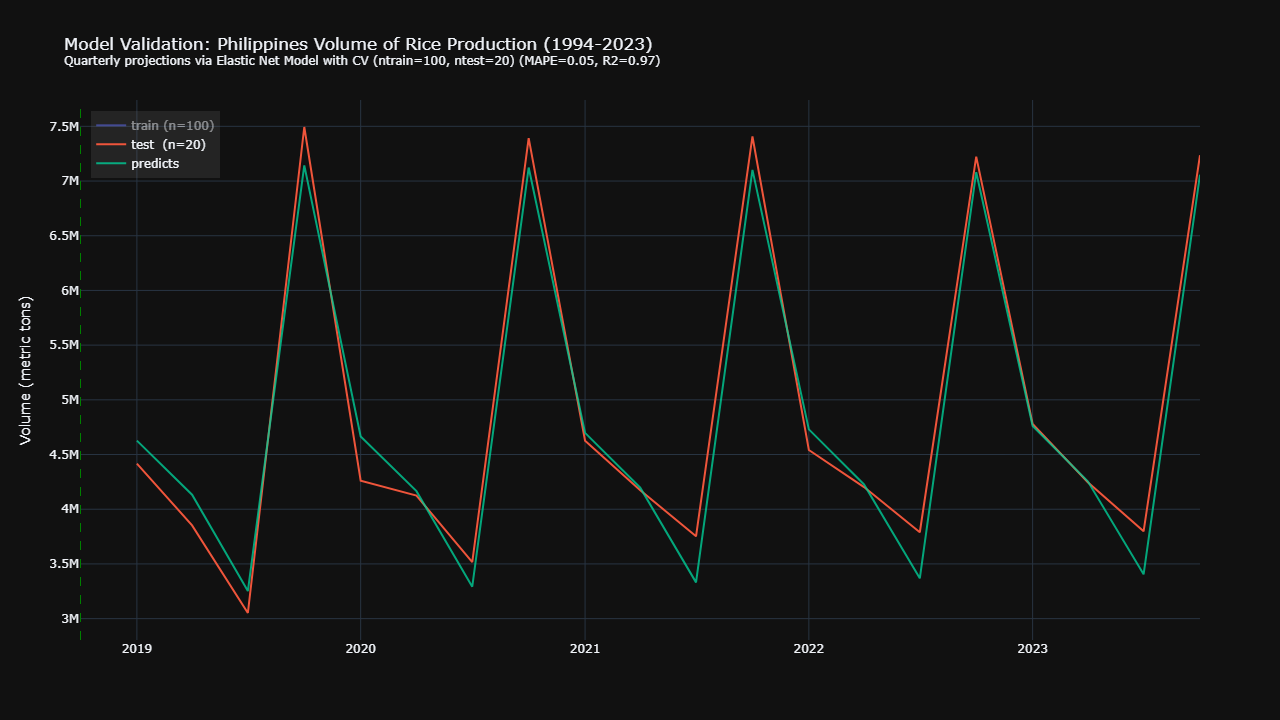

In [2025]:
import numpy as np
from sklearn.linear_model import BayesianRidge, ElasticNetCV, LarsCV, LassoCV, LassoLarsCV, OrthogonalMatchingPursuitCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor

# res = df.iloc[:, np.r_[2, 5:10]] # np.r to combine slices

# Set parameters
# Column numbers: 2: Farmgate Price, 3: Wholesale Price, 4: Retail Price, 5: CPI All Income, 6: NCR RPI
y = 'Volume'
X = np.r_[4]

# Split data into train-test
steps = 20
train = df[:-steps]
test  = df[-steps:]

train_y = train[y]
train_X = train.iloc[:, X]
test_y = test[y]
test_X = test.iloc[:, X]

print(
    f"Training periods : {train.index.min()} --- "
    f"{train.index.max()}  (n={len(train)})"
)
print(
    f"Testing periods  : {test.index.min()} --- "
    f"{test.index.max()}  (n={len(test)})"
)

# Find best hyperparameter values for forecaster
# regressors = [BayesianRidge(), ElasticNetCV(), RidgeCV(), LarsCV(), LassoCV(), LassoLarsCV(),
#               OrthogonalMatchingPursuitCV(), GradientBoostingRegressor(), BaggingRegressor(),
#               HistGradientBoostingRegressor(), ExtraTreesRegressor()]

forecaster = ForecasterAutoreg(
                regressor = ElasticNetCV(),
                lags      = 7
            )

# Candidate values for lags
lags_grid = list(range(6,30,1))

# Candidate values for regressor's hyperparameters
param_grid = {
    # 'cv': [5],
    # 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    # 'alpha': [0.5, 0.7, 0.9],
    # 'n_estimators': list(range(100, 500, 50)),
    # 'max_depth': list(range(3,10,1))
}

if False: 
    results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = train_y,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = steps,
                    refit              = False,
                    metric             = 'mean_absolute_percentage_error',
                    initial_train_size = int(len(train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )

# Use those best values for forecaster (automatically plugged in by grid_search_forecaster)
forecaster.fit(y=train_y)
forecaster

# Predictions
# NOTE: So if you want to have a more accurate projection, you may optionally measure these first,
# and much better if they are already available
predicts = forecaster.predict(steps=steps)
# predicts = forecaster.predict(steps=steps+27) #+28 to reach 2030
# predicts.index = pd.date_range(start=str(data_test.index.min()), end='2030Q4', freq='Q')
# display(predicts)

# Test MSE, RSME, R2
mse = metrics.mean_squared_error(y_true=test_y, y_pred=predicts)
rmse = metrics.root_mean_squared_error(y_true=test_y, y_pred=predicts)
mape = metrics.mean_absolute_percentage_error(y_true=test_y, y_pred=predicts)
r2 = metrics.r2_score(y_true=test_y, y_pred=predicts)

print("MSE:\t%0.2f" % mse)
print("RMSE:\t%0.2f" % rmse)
print("MAPE:\t%0.2f" % mape)
print("R2:\t%0.2f" % r2)

# Plot predicts versus test data
plot_results(train, test, predicts, var="Volume", title=f"Model Validation: Philippines Volume of Rice Production (1994-2023)\
    <br><sup>Quarterly projections via Elastic Net Model with CV (ntrain={len(train)}, ntest={len(test)}) (MAPE={round(mape,2)}, R2={round(r2,2)})</sup>",
    xtitle="Period", ytitle="Volume (metric tons)", split="2018-10-01 00:00:00")

Training periods : 1994-01-01 00:00:00 --- 2023-10-01 00:00:00  (n=120)


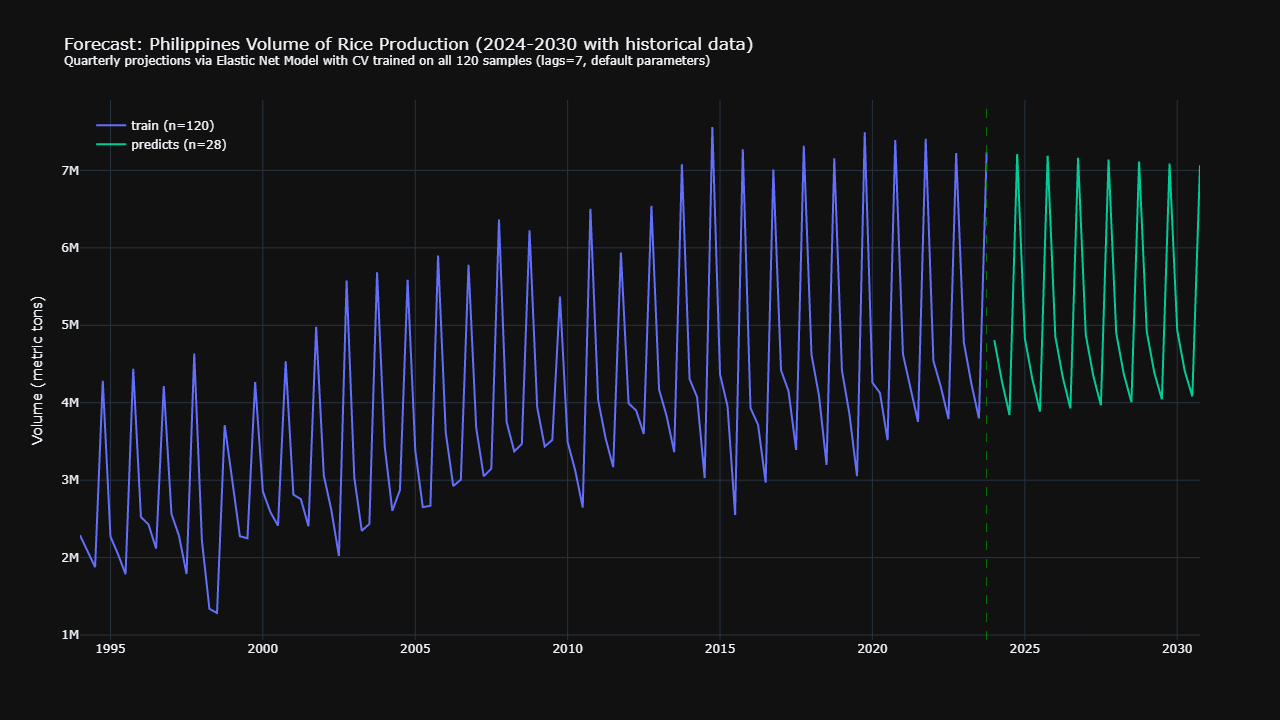

In [2026]:
train = df
train_y = df[y]
print(
    f"Training periods : {train.index.min()} --- "
    f"{train.index.max()}  (n={len(train)})"
)

forecaster = ForecasterAutoreg(
                regressor = ElasticNetCV(),
                lags      = 7
            )

forecaster.fit(train_y)
predicts = forecaster.predict(steps=28)

# Plot predicts versus test data

plot_results(train, None, predicts, "Volume", solo=True, title=f"Forecast: Philippines Volume of Rice Production (2024-2030 with historical data)\
    <br><sup>Quarterly projections via Elastic Net Model with CV trained on all {len(train)} samples (lags=7, default parameters)</sup>",
    xtitle="Period", ytitle="Volume (metric tons)", split="2023-10-01 00:00:00")

## Area Harvested Model

Training periods : 1994-01-01 00:00:00 --- 2018-10-01 00:00:00  (n=100)
Testing periods  : 2019-01-01 00:00:00 --- 2023-10-01 00:00:00  (n=20)
MSE:	2878843924.40
RMSE:	53654.86
MAPE:	0.04
R2:	0.98


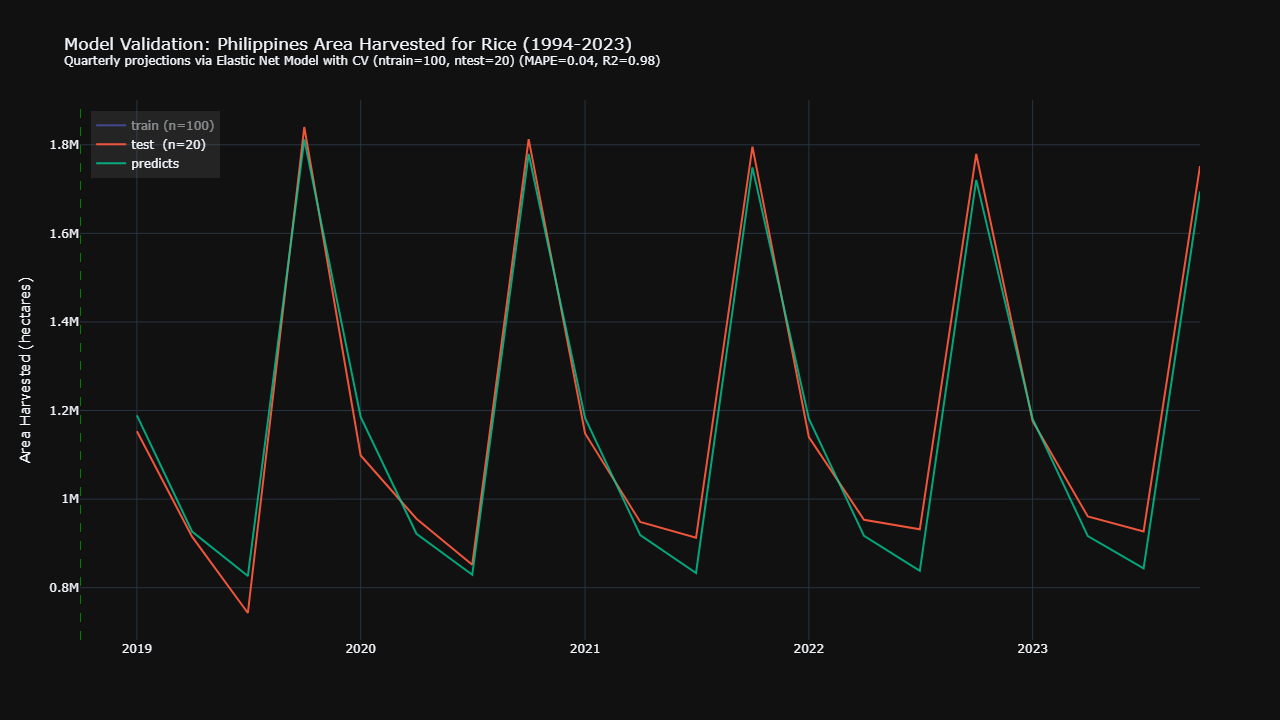

In [2027]:
import numpy as np
from sklearn.linear_model import BayesianRidge, ElasticNetCV, LarsCV, LassoCV, LassoLarsCV, OrthogonalMatchingPursuitCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor

# res = df.iloc[:, np.r_[2, 5:10]] # np.r to combine slices

# Set parameters
# Column numbers: 2: Farmgate Price, 3: Wholesale Price, 4: Retail Price, 5: CPI All Income, 6: NCR RPI
y = 'Area Harvested'
X = np.r_[4]

# Split data into train-test
steps = 20
train = df[:-steps]
test  = df[-steps:]

train_y = train[y]
train_X = train.iloc[:, X]
test_y = test[y]
test_X = test.iloc[:, X]

print(
    f"Training periods : {train.index.min()} --- "
    f"{train.index.max()}  (n={len(train)})"
)
print(
    f"Testing periods  : {test.index.min()} --- "
    f"{test.index.max()}  (n={len(test)})"
)

# Find best hyperparameter values for forecaster
# regressors = [BayesianRidge(), ElasticNetCV(), RidgeCV(), LarsCV(), LassoCV(), LassoLarsCV(),
#               OrthogonalMatchingPursuitCV(), GradientBoostingRegressor(), BaggingRegressor(),
#               HistGradientBoostingRegressor(), ExtraTreesRegressor()]

forecaster = ForecasterAutoreg(
                regressor = ElasticNetCV(),
                lags      = 7
            )

# Candidate values for lags
lags_grid = list(range(6,30,1))

# Candidate values for regressor's hyperparameters
param_grid = {
    # 'cv': [5],
    # 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    # 'alpha': [0.5, 0.7, 0.9],
    # 'n_estimators': list(range(100, 500, 50)),
    # 'max_depth': list(range(3,10,1))
}

if False: 
    results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = train_y,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = steps,
                    refit              = False,
                    metric             = 'mean_absolute_percentage_error',
                    initial_train_size = int(len(train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )

# Use those best values for forecaster (automatically plugged in by grid_search_forecaster)
forecaster.fit(y=train_y)
forecaster

# Predictions
# NOTE: So if you want to have a more accurate projection, you may optionally measure these first,
# and much better if they are already available
predicts = forecaster.predict(steps=steps)
# predicts = forecaster.predict(steps=steps+27) #+28 to reach 2030
# predicts.index = pd.date_range(start=str(data_test.index.min()), end='2030Q4', freq='Q')
# display(predicts)

# Test MSE, RSME, R2
mse = metrics.mean_squared_error(y_true=test_y, y_pred=predicts)
rmse = metrics.root_mean_squared_error(y_true=test_y, y_pred=predicts)
mape = metrics.mean_absolute_percentage_error(y_true=test_y, y_pred=predicts)
r2 = metrics.r2_score(y_true=test_y, y_pred=predicts)

print("MSE:\t%0.2f" % mse)
print("RMSE:\t%0.2f" % rmse)
print("MAPE:\t%0.2f" % mape)
print("R2:\t%0.2f" % r2)

# Plot predicts versus test data
plot_results(train, test, predicts, var="Area Harvested", title=f"Model Validation: Philippines Area Harvested for Rice (1994-2023)\
    <br><sup>Quarterly projections via Elastic Net Model with CV (ntrain={len(train)}, ntest={len(test)}) (MAPE={round(mape,2)}, R2={round(r2,2)})</sup>",
    xtitle="Period", ytitle="Area Harvested (hectares)", split="2018-10-01 00:00:00")

Training periods : 1994-01-01 00:00:00 --- 2023-10-01 00:00:00  (n=120)


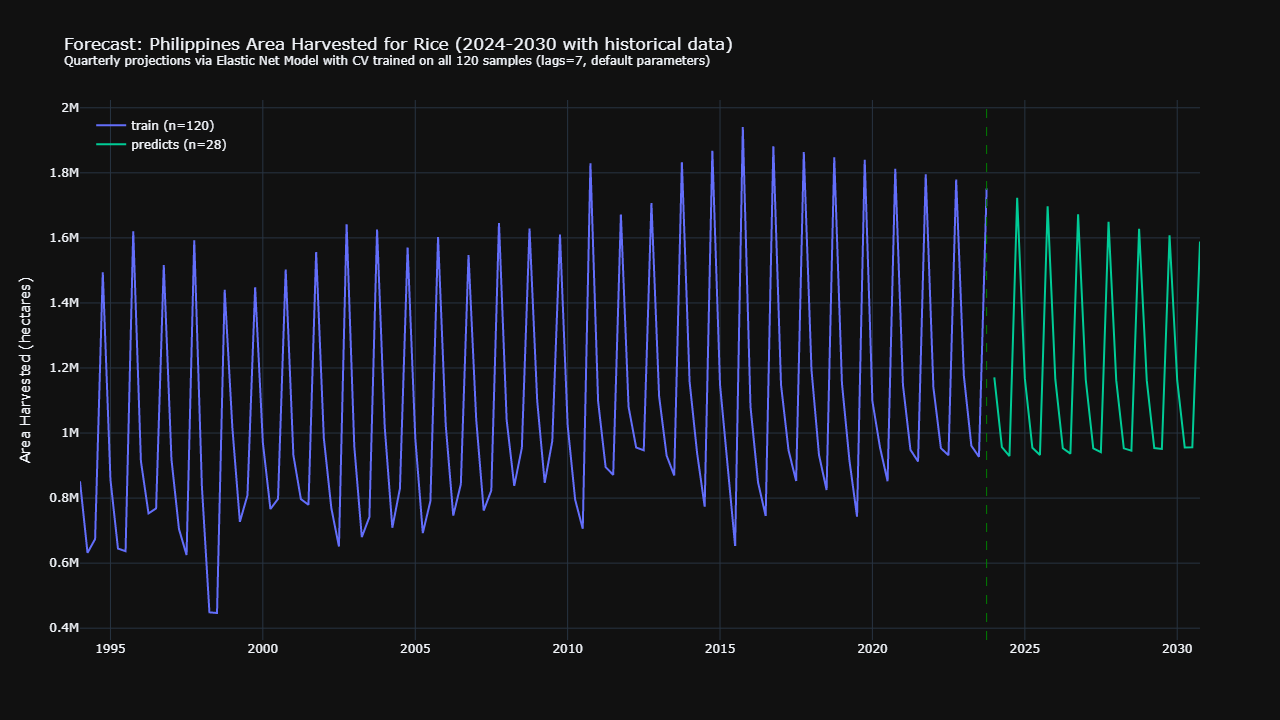

In [2028]:
train = df
train_y = df[y]
print(
    f"Training periods : {train.index.min()} --- "
    f"{train.index.max()}  (n={len(train)})"
)

forecaster = ForecasterAutoreg(
                regressor = ElasticNetCV(),
                lags      = 7
            )

forecaster.fit(train_y)
predicts = forecaster.predict(steps=28)

# Plot predicts versus test data

plot_results(train, None, predicts, "Area Harvested", solo=True, title=f"Forecast: Philippines Area Harvested for Rice (2024-2030 with historical data)\
    <br><sup>Quarterly projections via Elastic Net Model with CV trained on all {len(train)} samples (lags=7, default parameters)</sup>",
    xtitle="Period", ytitle="Area Harvested (hectares)", split="2023-10-01 00:00:00")

# Stocks Analysis

In [2029]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import TimeSeriesSplit

df1 = pd.read_csv("datasets/agricultural-indicators/stocks-palay-corn_yearly_1980-2024.csv")
df1 = df1[df1["Sector"] == "Rice: Total Stock"]
df1["Sector"] = df1["Sector"].replace({"Rice: Total Stock": "Rice"})
df1 = df1.melt(["Sector", "Year"], df1.columns[2:], "Month", "Stocks")
df1["Year"] = df1["Year"].astype(str)
df1["Period"] =  df1["Year"] + " " + df1["Month"]
df1 = df1.rename({"Sector": "Commodity"}, axis=1)
df1 = df1.drop(["Year", "Month"], axis=1)

# Monthly Analysis for Rice Stocks only

# Farmgate Price of Rice and Corn
df2 = pd.read_csv("datasets/prices/prices_farmgate-new-series_1990-2023.csv", na_values=[".."])
df2 = df2[df2.Geolocation == "PHILIPPINES"]
df2 = remove_annuals(df2)
df2 = preprocess_baesians_2(df2, {"Palay [Paddy] Other Variety, dry (conv. to 14% mc)": "Rice"}, melt_value="Farmgate Price", impute=True).copy()

# Wholesale Price of Rice and Corn
df3 = pd.read_csv("datasets/prices/prices_wholesale-new-series_1990-2023.csv", na_values=[".."])
df3 = df3[df3.Geolocation == "PHILIPPINES"]
df3 = remove_annuals(df3)
df3 = preprocess_baesians_2(df3, {"Well Milled Rice (WMR)": "Rice"}, melt_value="Wholesale Price", impute=True)

# Retail Price of Rice and Corn
df4 = pd.read_csv("datasets/prices/prices_retail_1990-2023.csv", na_values=[".."])
df4 = df4[df4.Geolocation == "PHILIPPINES"]
df4 = remove_annuals(df4)
df4 = preprocess_baesians_2(df4, {
                                  "Regular Milled Rice (RMR)" : "Rice"}, melt_value="Retail Price", impute=True)

# Consumer Price Index (All Income) per Region of Rice and Corn (from monthly)
df6 = pd.read_csv("datasets/price-indices-2018-based/cpi_all-income-households-by-cg-with-backcasting_1994-2023.csv")
df6 = df6[df6.Geolocation == "PHILIPPINES"]
df6 = preprocess_baesians_2(df6, {"01.1.1.12 - Rice": "Rice"},
                            melt_value="CPI All Income")

# NCR Retail Price Index on Food
df10 = pd.read_csv("datasets/price-indices-2018-based/rpi-in-ncr_food-only_1989-2023_new.csv")
df10 = preprocess_baesians_2(df10, {"..Food": "Food"}, melt_value="NCR RPI").drop(["Geolocation", "Commodity"], axis=1)

# # Merge all dfs into a single df
dfs = [df1, df2, df3, df4, df6, df10]
df = functools.reduce(lambda left, right: pd.merge(left, right), dfs)
df.drop(["Commodity", "Geolocation"], axis=1, inplace=True)
df["Period"] = pd.to_datetime(df["Period"], format="%Y %b")
df = df.set_index("Period")
df = df[df.index < "2024"]
df = df.asfreq("MS")
df = df.sort_index()

display(df.head(12))

print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')
print(df.shape)


,Stocks,Farmgate Price,Wholesale Price,Retail Price,CPI All Income,NCR RPI
Period,,,,,,
1994-01-01,1444.3,5.70,11.60,11.60,31.448192,44.451220
1994-02-01,1157.0,5.88,11.70,11.76,31.558730,44.024390
1994-03-01,1092.6,5.68,11.61,11.69,31.614000,44.024390
1994-04-01,1362.4,5.85,11.65,11.75,31.669269,44.207317
1994-05-01,1408.2,5.90,11.78,11.85,31.779807,44.695122
1994-06-01,1353.6,6.11,11.94,11.97,31.890346,44.878049
1994-07-01,1258.0,6.34,12.50,12.55,32.221961,45.426829
1994-08-01,989.9,6.39,12.99,13.00,32.719384,45.792683
1994-09-01,888.9,6.02,12.91,12.99,32.774654,45.426829


Number of rows with missing values: 0.0
(360, 6)


Training periods : 1994-01-01 00:00:00 --- 2019-10-01 00:00:00  (n=310)
Testing periods  : 2019-11-01 00:00:00 --- 2023-12-01 00:00:00  (n=50)
RandomForestRegressor(random_state=100)
MSE:	60572.06
RMSE:	246.11
MAPE:	0.10
R2:	0.70


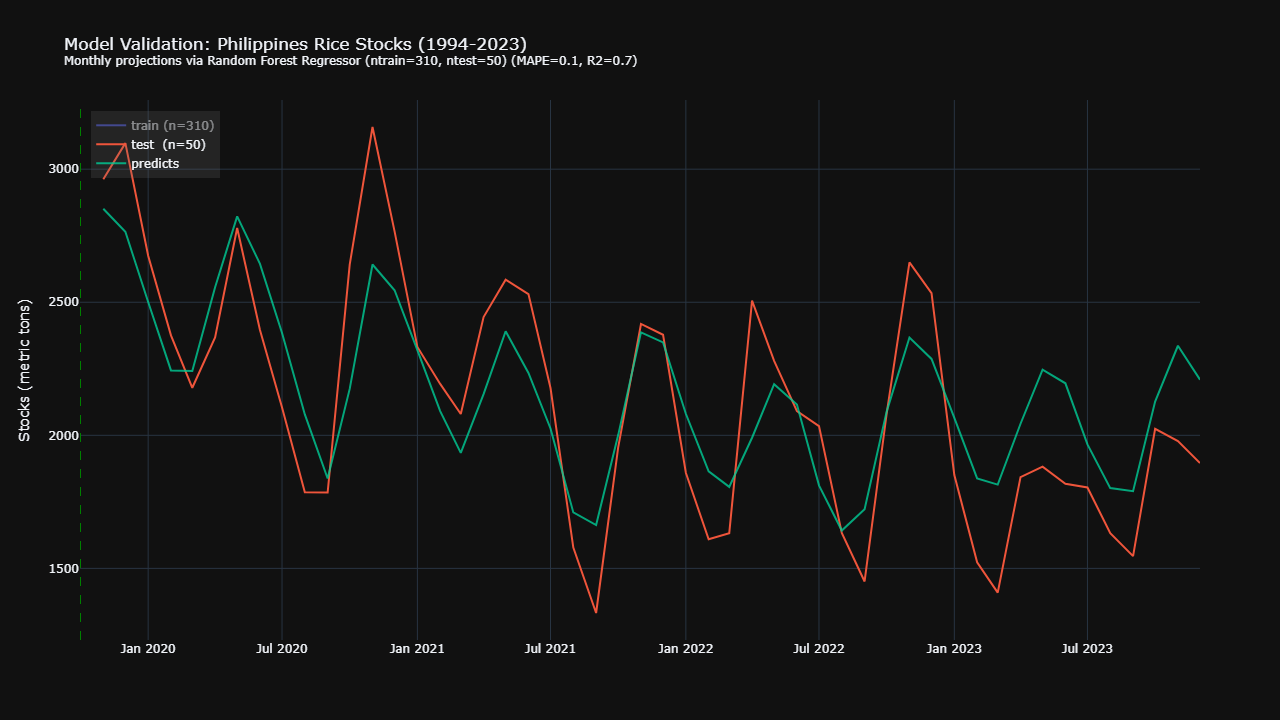

In [2030]:
import numpy as np
from sklearn.linear_model import BayesianRidge, ElasticNetCV, LarsCV, LassoCV, LassoLarsCV, OrthogonalMatchingPursuitCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
import itertools

# res = df.iloc[:, np.r_[2, 5:10]] # np.r to combine slices

# Set parameters
# Column numbers: 1: Farmgate Price, 2: Wholesale Price, 3: Retail Price, 4: CPI All Income, 5: NCR RPI
y = 'Stocks'
# for choices in itertools.combinations((1,2,3,4,5), 4):
X = np.r_[5]

# Split data into train-test
steps = 50
train = df[:-steps]
test  = df[-steps:]

train_y = train[y]
train_X = train.iloc[:, X]
test_y = test[y]
test_X = test.iloc[:, X]

use_exog = False

print(
    f"Training periods : {train.index.min()} --- "
    f"{train.index.max()}  (n={len(train)})"
)
print(
    f"Testing periods  : {test.index.min()} --- "
    f"{test.index.max()}  (n={len(test)})"
)

# Find best hyperparameter values for forecaster
regressors = [BayesianRidge(), ElasticNetCV(), RidgeCV(), LarsCV(), LassoCV(), LassoLarsCV(),
            OrthogonalMatchingPursuitCV(), GradientBoostingRegressor(), BaggingRegressor(),
            HistGradientBoostingRegressor(), ExtraTreesRegressor(), RandomForestRegressor()]
regressor = RandomForestRegressor(random_state=100)
print(regressor)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 18
            )

# regressor = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=123)
# forecaster = ForecasterAutoreg(regressor=regressor, lags=20)

# Candidate values for lags
lags_grid = list(range(6,30,1))

# Candidate values for regressor's hyperparameters
param_grid = {
    # 'cv': [5],
    # 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    # 'alpha': [0.5, 0.7, 0.9],
    # 'n_estimators': list(range(100, 500, 50)),
    # 'max_depth': list(range(3,10,1))
}

if False: 
    results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = train_y,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = steps,
                    refit              = False,
                    metric             = 'mean_absolute_percentage_error',
                    initial_train_size = int(len(train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )

# Use those best values for forecaster (automatically plugged in by grid_search_forecaster)
forecaster.fit(y=train_y, exog=train_X) if use_exog else forecaster.fit(y=train_y)
forecaster

# Predictions
# NOTE: So if you want to have a more accurate projection, you may optionally measure these first,
# and much better if they are already available
predicts = forecaster.predict(steps=steps, exog=test_X) if use_exog else forecaster.predict(steps=steps)
# predicts = forecaster.predict(steps=steps+27) #+28 to reach 2030
# predicts.index = pd.date_range(start=str(data_test.index.min()), end='2030Q4', freq='Q')
# display(predicts)

# Test MSE, RSME, R2
mse = metrics.mean_squared_error(y_true=test_y, y_pred=predicts)
rmse = metrics.root_mean_squared_error(y_true=test_y, y_pred=predicts)
mape = metrics.mean_absolute_percentage_error(y_true=test_y, y_pred=predicts)
r2 = metrics.r2_score(y_true=test_y, y_pred=predicts)

print("MSE:\t%0.2f" % mse)
print("RMSE:\t%0.2f" % rmse)
print("MAPE:\t%0.2f" % mape)
print("R2:\t%0.2f" % r2)

# Plot predicts versus test data
plot_results(train, test, predicts, var="Stocks", title=f"Model Validation: Philippines Rice Stocks (1994-2023)\
    <br><sup>Monthly projections via Random Forest Regressor (ntrain={len(train)}, ntest={len(test)}) (MAPE={round(mape,2)}, R2={round(r2,2)})</sup>",
    xtitle="Period", ytitle="Stocks (metric tons)", split="2019-10-01 00:00:00")


Training periods : 1994-01-01 00:00:00 --- 2023-12-01 00:00:00  (n=360)


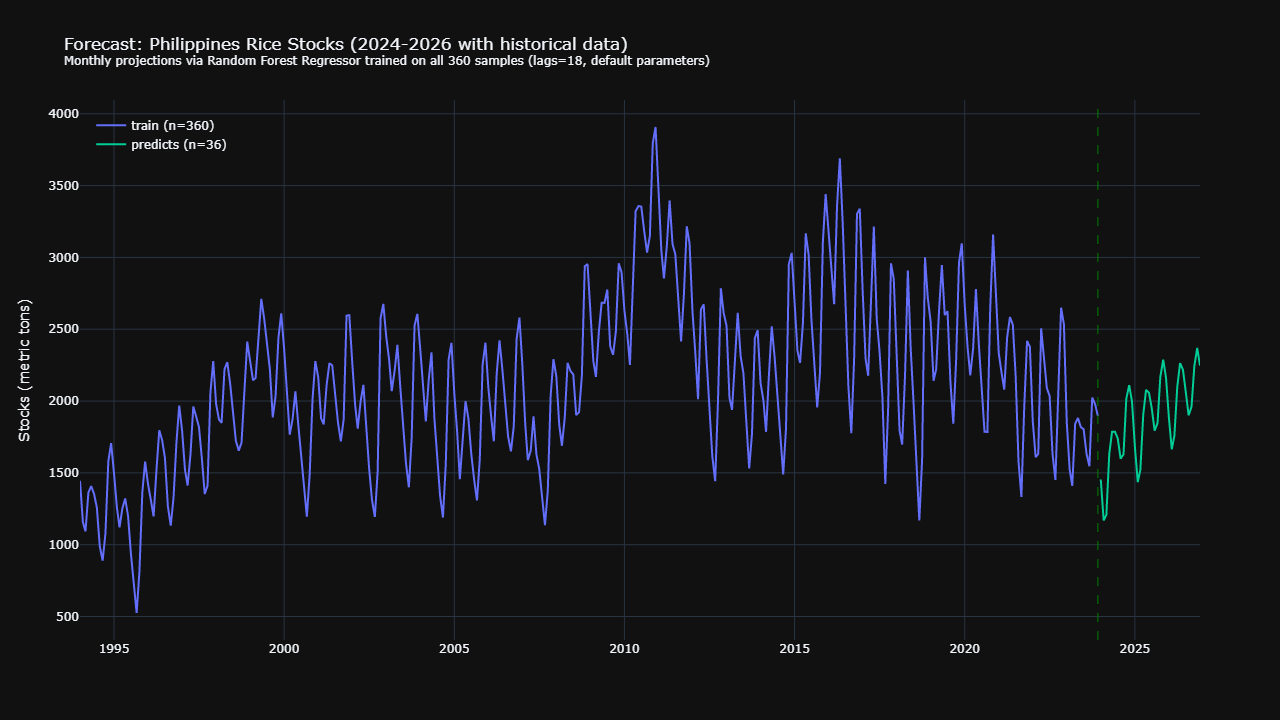

In [2031]:
train = df
train_y = df[y]
print(
    f"Training periods : {train.index.min()} --- "
    f"{train.index.max()}  (n={len(train)})"
)

forecaster = ForecasterAutoreg(
                regressor = ElasticNetCV(),
                lags      = 18
            )

forecaster.fit(train_y)
predicts = forecaster.predict(steps=36)

# Plot predicts versus test data

plot_results(train, None, predicts, "Stocks", solo=True, title="Forecast: Philippines Rice Stocks (2024-2026 with historical data)\
    <br><sup>Monthly projections via Random Forest Regressor trained on all 360 samples (lags=18, default parameters)</sup>",
    xtitle="Period", ytitle="Stocks (metric tons)", split="2023-12-01 00:00:00")